# U12 Abdullah Barhoum (5041774), Katharina Müller (5284090)

# Assignment 12

In this tutorium, we will work on GANs networks (https://arxiv.org/pdf/1406.2661.pdf). This kind of network is part of the generative networks who are actually able to generate synthetic data. This network is actually composed of two, a generator responsible for generate fake data and a discriminator for investigating on the trueness of the images.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pathmind.com/images/wiki/GANs.png", width=700)

The disciminator can be see as a very simple fully connected network, composed of several layer of neurons and a simple output of one neurone who just determine if a image is true or false.

The generator looks more like the upscaling part of the segmenetation network. A small piece of noise is injected and the output is an images. 

The training is maybe the most original part. 

First, you train the discriminator alone by injecting the training set (True data so label=True) and a set of data generated by the generator (label=False) you then have a loss to back propagate. *Applause, you trained you discriminator for one batch*

Second, you inject some noise in your generator, the generator produce some fake images, you inject this fake images in you discriminator and use the labels generated by the discriminator to compute your backpropagation. So to train your generator, you will consider the generator and the discriminator as the same network, you just don't train the discriminator in this case.

## 12.1

We ask you then to program you own GANs. this network should be just compose of fully connected layer (no conv). You should define the architecture of the network, then provide two training function one for the generator and one for the discriminator and make him learn!

We will take the MNIST dataset here for simplicity and lightness. The architecture I used was :

G : (Input : random Tensor = 100) => (FC1 : fully connected = 256) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 784) =>  (Tanh)

D : (Input : flatten images Tensor = 784) => (FC1 : fully connected = 1024) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 1) =>  (Sigmoid)

This architecture is what I use, it's working but not great, so feel free to change it!!

The training is 20-30min on a 1060 6Go for 100 epochs and batch size of 100. Here, it's a little bit different than before, the loss do not necessarly go done, it's a race between D and G so both cannot be good at the same time.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [7]:
batch_size = 32

train_loader = DataLoader(
    MNIST(root='./data/', train=True, download=True, transform = T.Compose([
        T.ToTensor(), 
        T.Normalize(mean=(0.5,), std=(0.5,))
    ])),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

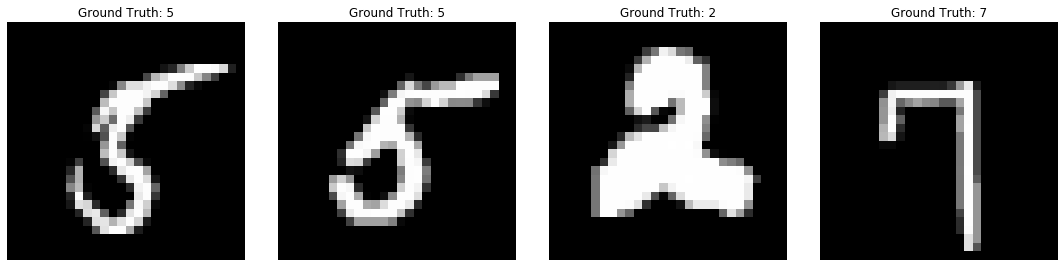

In [8]:
example_data, example_targets = next(iter(train_loader))

fig = plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.axis('off')
plt.show()

In [ ]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

z_size = 49

generator = nn.Sequential(
    nn.Linear(z_size, 49 * 3),
    nn.LeakyReLU(0.5),
    nn.BatchNorm1d(49 * 3),

    # shape [batch, 49 * 3]
    Reshape((3, 7, 7)),
    nn.ConvTranspose2d(3, 2, 4, 2, 1),
    nn.LeakyReLU(0.5),
    nn.BatchNorm2d(2),

    # shape [batch, 2, 14, 14]
    nn.ConvTranspose2d(2, 1, 4, 2, 1),
    
    # shape [batch, 1, 28, 28]
    Reshape((28, 28)),
    nn.Tanh(),
).to(device)


discriminator = nn.Sequential(
    Reshape((1, 28, 28)),
    nn.Conv2d(1, 2, 4, 2, 1),
    nn.ReLU(),
    nn.BatchNorm2d(2),

    # shape [batch, 2, 14, 14]
    nn.Conv2d(2, 3, 4, 2, 1),
    nn.ReLU(),
    nn.BatchNorm2d(3),

    # shape [batch, 3, 7, 7]
    nn.Flatten(),

    # shape [batch, 3 * 7 * 7]
    nn.Linear(3 * 7 * 7, 1),
    nn.Sigmoid()
).to(device)



g_optim = torch.optim.Adam(generator.parameters())
d_optim = torch.optim.Adam(discriminator.parameters())

In [ ]:
loss_crit = torch.nn.BCELoss()

ones = torch.ones((batch_size, 1)).to(device)
zeros = torch.zeros((batch_size, 1)).to(device)
samples_z = torch.rand((batch_size, z_size)).to(device)

losses = []
num_epochs = 10
for e in tqdm(range(num_epochs), leave=False):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        # train the generator
        g_optim.zero_grad()
        z = torch.rand((batch_size, z_size)).to(device)
        fake_imgs = generator(z)
        g_loss = loss_crit(discriminator(fake_imgs), ones)
        g_loss.backward(retain_graph = True)
        g_optim.step()

        # train the discriminator
        d_optim.zero_grad()
        d_loss = (
            loss_crit(discriminator(images), ones)
            + 
            loss_crit(discriminator(fake_imgs), zeros)
        )
        d_loss.backward()
        d_optim.step()
        if i % 10 == 0:
            losses.append([g_loss.item(), d_loss.item()])

        if i % 1000 == 0:
            samples = generator(samples_z).view(-1, 1, 28, 28)
            save_image(make_grid(samples), f"generated/{e}_{i}.png")

In [ ]:
plt.figure(figsize=(20, 5))
losses = np.array(losses)
plt.plot(losses[:, 0], label='generator')
plt.plot(losses[:, 1], label='discrimnator')
plt.title('losses')
plt.legend()
plt.show()

## 8.2 Bonus
For the bonus, fancy stuff we would like you to program a conditional GAN. This GAN should produce the output you want. Instead of feeding your generator with just noise, you feed it with noise and label and it should generated the number you want. 
To do so, you add a label part to your Generator's input and you tell your discriminator what number it should recognize by adding a label part to your Discriminator's input.


In [10]:
Image(url= "https://raw.githubusercontent.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/master/pytorch_cGAN.png", width=900)

In [ ]:
#ToDo